In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, plot_metric, make_axis_great_again, plot_epochs
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '06.05_12.05_solving_the_MLP_problem'

human36m_alg_AlgebraicTriangulationNet@07.05.2021-14:45:57 (from /home/stefano/Scuola/now/thesis/milestones/06.05_12.05_solving_the_MLP_problem/15169032.out)
training on 12, evaluating on 5
found 110 epochs
training loss in [4.4, 6.0]
training metrics in [104425.8, 14298298.7]
eval metrics in [22138.3, 696361.1]
- plotted "L2" metrics [2.2, 3.0] in epochs [0, 109]
- plotted "geodesic" metrics [2.7, 3.1] in epochs [0, 109]


Text(0.5, 0.98, 'cam2cam estimation (using predicted keypoints using L2 on projections on 12 / 5 train / validation images) optimizing just last 3 layers of BB, lr BB=1e-6')

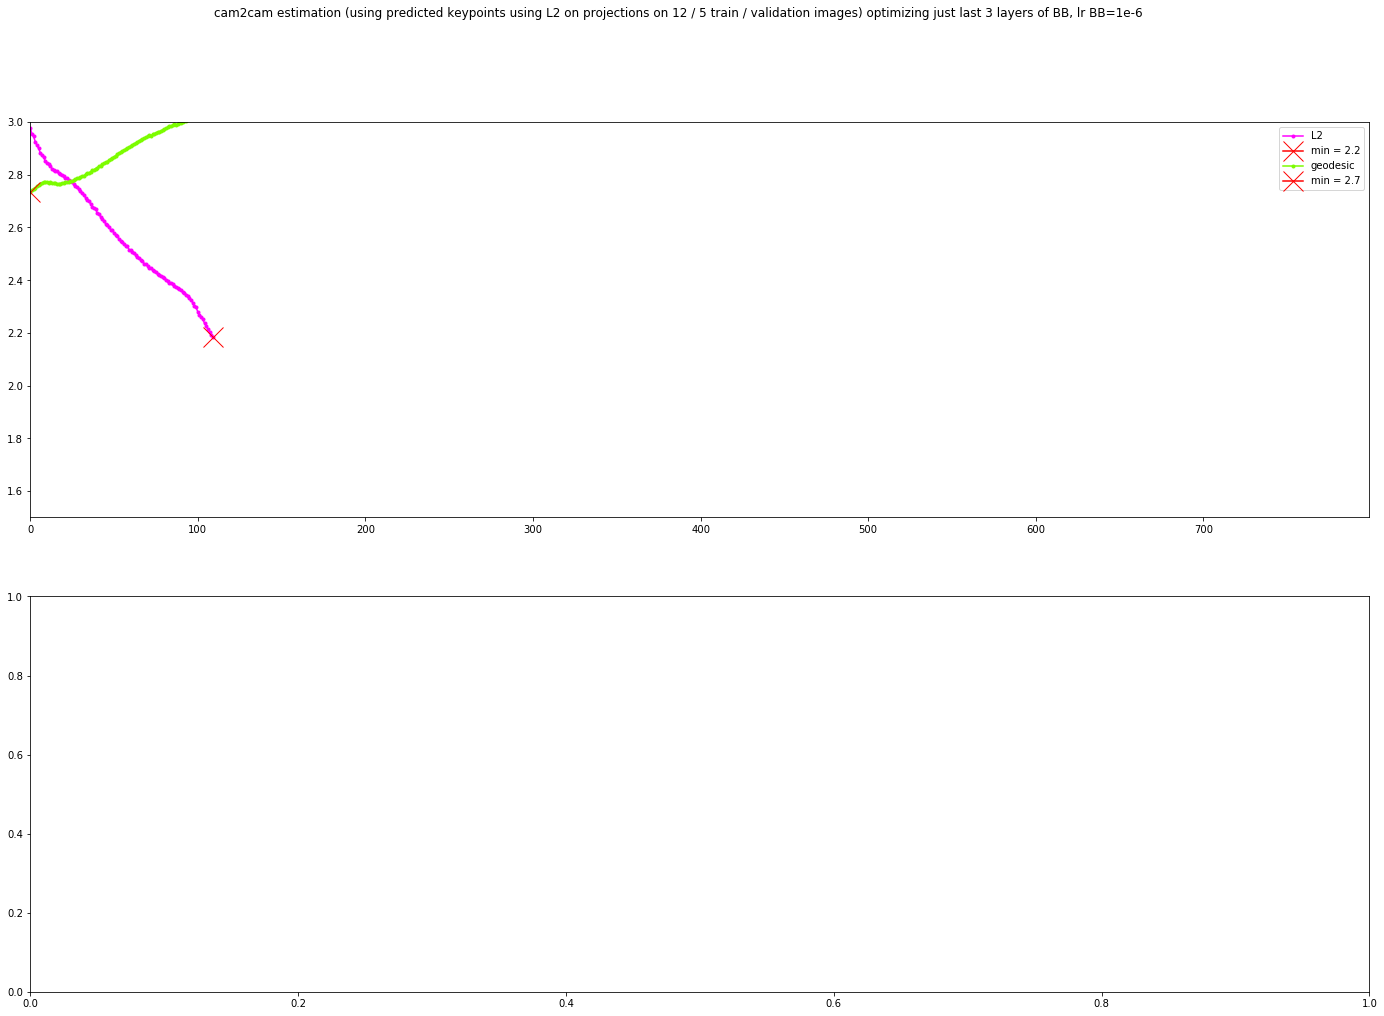

In [44]:
fig, axis = get_figa(2, 1, heigth=8, width=24)
metrics_ylim = [0, 1e3]
max_epochs = 800

job_id = '15169032'
exp_name, _, _, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
losses = parse_epochs(epochs)
ax = axis.ravel()[0]

plot_metric(
    ax,
    losses['roto loss / batch'],
    'L2',
    color='magenta',
    show_min=True,
    marker='.',
    verbose=True
)

plot_metric(
    ax,
    losses['geo loss / batch'],
    'geodesic',
    color='lawngreen',
    show_min=True,
    marker='.',
    verbose=True
)

ax.legend()

make_axis_great_again(ax, xlim=[0, max_epochs - 1], ylim=[1.5, 3], hide_y=False)

job_id = ''
# exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
# ax = axis.ravel()[1]
# plot_epochs(
#     ax, epochs,
#     train_metric_ylim=metrics_ylim,
#     eval_metric_ylim=metrics_ylim,
#     loss_ylim=[0, 5e4],
#     title='MLP pro: 20 layers x 512 units + Dropout(p=0.1)',
#     metric_ylabel='average MPJPE relative to pelvis (mm)'
# )
# ax.set_xlim([0, max_epochs - 1])

fig.suptitle('cam2cam estimation (using predicted keypoints using L2 on projections on 12 / 5 train / validation images) optimizing just last 3 layers of BB, lr BB=1e-6')
# .png